# Grammar
Grammar rules object and finite grammar object.

In [1]:
from estnltk.finite_grammar.trees import Rule, Grammar

rules = []
rules.append(Rule('S', 'A'))
rules.append(Rule('S', 'B'))
rules.append(Rule('A', 'BF'))
rules.append(Rule('B', 'G'))

grammar = Grammar(start_symbol='S', rules=rules)
grammar


Grammar:
	start: 'S',
	terminals: 'F', 'G'
	nonterminals: 'A', 'B', 'S'
Rules:
	'S' -> 'A'	: 1
	'S' -> 'B'	: 1
	'A' -> 'B', 'F'	: 2
	'B' -> 'G'	: 1

In [2]:
grammar.rules[2]

'A' -> 'B', 'F'	: 2

# Phrase list generator
Generates all phrases of the finite grammar.

In [3]:
from estnltk.finite_grammar import phrase_list_generator

for phrase in phrase_list_generator(grammar, depth=float('inf')):
    print(phrase)

['G', 'F']
['G']


# Graph from document

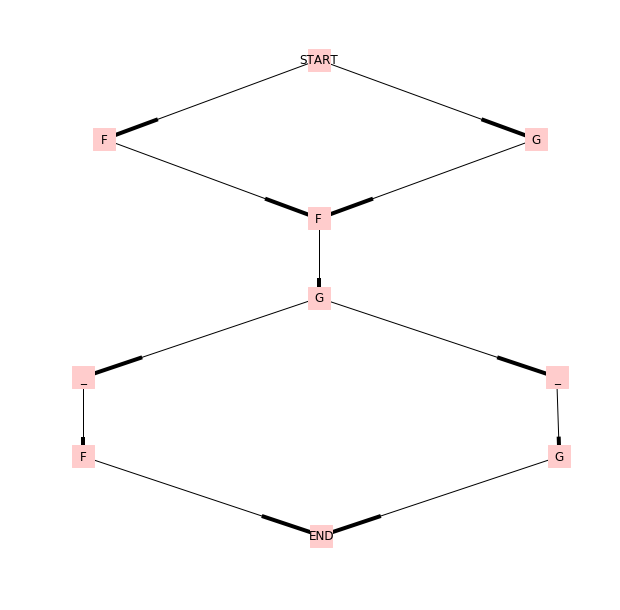

In [4]:
from estnltk.finite_grammar.trees import plot_graph, graph_from_document

document = {'F':[(1,4),(5,10),          (17,19)], 
            'G':[(1,4),       (11, 13), (15,19)]}

graph = graph_from_document(document)
plot_graph(graph)

# PhraseListTagger
## Example 1

In [5]:
from estnltk import Text
text_1 = Text('Patsient lasi jalga, sest vasaku jala suure varba pika \
               painutajalihase kõõluse rebend ajas tal kopsu üle maksa.')
text_1.analyse('morphology')

Text(text="Patsient lasi jalga, sest vasaku jala suure varba pika                painutajalihase kõõluse rebend ajas tal kopsu üle maksa.")

In [6]:
from estnltk.finite_grammar import PhraseListTagger

phrase_list = [
               ('jalg'),
               ('vasak', 'jalg',),
               ('parem', 'jalg',),
               ('kops',),
               ('vasak', 'kops'),
               ('parem', 'kops'),
               ('kõõlus',),
               ('lihas',),
               ('maks',),
               ('neer',),
               ('parem', 'neer'),
               ('vasak', 'neer'),
               ('varvas',),
               ('suur', 'varvas'),
              ]

def decorator(text, span, phrase):
    return {'match': phrase, 'dfsd':None}

def consistency_checker(text, span, phrase):
    return True

tagger = PhraseListTagger(layer_name='body_parts',
                          input_layer='morph_analysis',
                          input_attribute='lemma',
                          phrase_list=phrase_list,
                          attributes=('match',),
                          decorator=decorator,
                          consistency_checker=consistency_checker,
                          conflict_resolving_strategy= 'MAX')
tagger

In [7]:
tagger.tag(text_1)

Text(text="Patsient lasi jalga, sest vasaku jala suure varba pika                painutajalihase kõõluse rebend ajas tal kopsu üle maksa.")

In [8]:
text_1['body_parts']

Note that 'maksa' is not tagged. This is because Vabamorf thinks its lemma is 'maksma'.

## Example 2: postprocessing
Suppose that we want to postprocess the layer before adding it to the text object. Here we add an attribute 'latin_term' to the layer.

In [9]:
text = Text('Vasaku jala suure varba pika painutajalihase kõõluse rebend ajas patsiendi kopsu üle maksa.')
text.analyse('morphology')
latin_dict = {('suur', 'varvas'):'hallux', ('kõõlus',):'tendo', ('kops',):'pulmo'}

layer = tagger.tag(text, return_layer=True)
layer.attributes = ('match','latin_term')
for s in layer:
    s.latin_term = latin_dict[s.match]
text['body_parts'] = layer
text['body_parts']

## Example 3

In [10]:
text = Text('Naeris naeris.')
text.analyse('morphology')

Text(text="Naeris naeris.")

Create one more layer of morphological analysis.

In [11]:
from estnltk.taggers import VabamorfTagger
tagger = VabamorfTagger(layer_name='morph_analysis_no_disambiguate',
                        disambiguate=False)
tagger.tag(text)['morph_analysis_no_disambiguate']

In [12]:
from estnltk.resolve_layer_dag import make_resolver

def decorator(text, span, phrase):
    return {'match': phrase}

tagger = PhraseListTagger('test',
                          'morph_analysis_no_disambiguate',
                          'lemma',
                          [
                            ('naerma', 'naerma'),
                            ('naerma', 'naeris'),
                            ('naeris', 'naerma'),
                            ('naeris', 'naeris'),
                          ],
                          attributes=('match',),
                          decorator=decorator,
                          conflict_resolving_strategy='ALL')
tagger.tag(text)
text['test']

# Layer to graph
Here we use the text from Example 3.

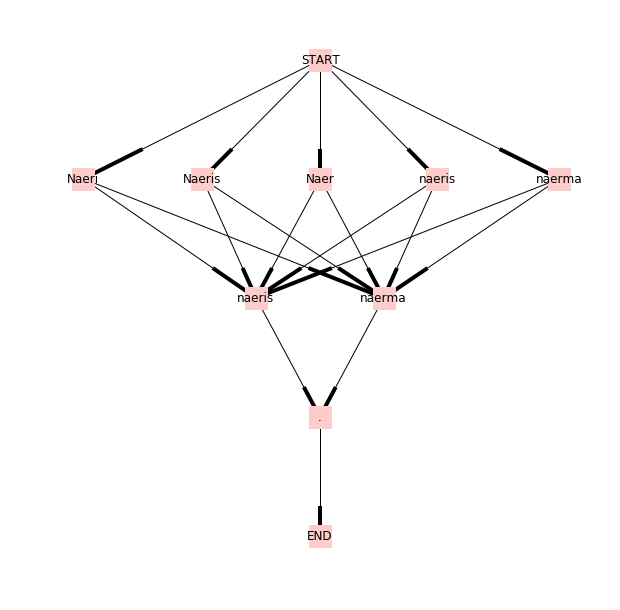

In [13]:
from estnltk.finite_grammar.trees import layer_to_graph_by_attribute

g = layer_to_graph_by_attribute(text['morph_analysis_no_disambiguate'], 'lemma')
plot_graph(g)

# Millised peaksid olema decorator'i, consistency_checker'i argumendid?

Näiteks olgu meil mitmene morph_analysis kiht ja matchime lemmasid ('naeris', 'naerma'). Kui anname ette mitmese spanni (seitsmene spanlist + neljane spanlist), siis ei ole üheselt selge milliseid lemmasid õnnestus matchida. Kui anname ette konkreetsed spanid, mis matchisid, näiteks kuuenda ja esimese, siis pole kindel, et parem poleks olnud ette anda hoopis seitsmendat ja esimest.

In [14]:
text.morph_analysis_no_disambiguate

SL[SL[Span(Naeris, {'root_tokens': ('Naer',), 'root': 'Naer', 'partofspeech': 'H', 'lemma': 'Naer', 'clitic': '', 'ending': 's', 'form': 'sg in'}),
Span(Naeris, {'root_tokens': ('Naeri',), 'root': 'Naeri', 'partofspeech': 'H', 'lemma': 'Naeri', 'clitic': '', 'ending': 's', 'form': 'sg in'}),
Span(Naeris, {'root_tokens': ('Naeris',), 'root': 'Naeris', 'partofspeech': 'H', 'lemma': 'Naeris', 'clitic': '', 'ending': '0', 'form': 'sg n'}),
Span(Naeris, {'root_tokens': ('Naeris',), 'root': 'Naeris', 'partofspeech': 'H', 'lemma': 'Naeris', 'clitic': '', 'ending': 's', 'form': 'sg in'}),
Span(Naeris, {'root_tokens': ('naer',), 'root': 'naer', 'partofspeech': 'V', 'lemma': 'naerma', 'clitic': '', 'ending': 'is', 'form': 's'}),
Span(Naeris, {'root_tokens': ('naeris',), 'root': 'naeris', 'partofspeech': 'S', 'lemma': 'naeris', 'clitic': '', 'ending': '0', 'form': 'sg n'}),
Span(Naeris, {'root_tokens': ('naeris',), 'root': 'naeris', 'partofspeech': 'S', 'lemma': 'naeris', 'clitic': '', 'ending': 's', 'form': 'sg in'})],
SL[Span(naeris, {'root_tokens': ('naer',), 'root': 'naer', 'partofspeech': 'V', 'lemma': 'naerma', 'clitic': '', 'ending': 'is', 'form': 's'}),
Span(naeris, {'root_tokens': ('naeris',), 'root': 'naeris', 'partofspeech': 'S', 'lemma': 'naeris', 'clitic': '', 'ending': '0', 'form': 'sg n'}),
Span(naeris, {'root_tokens': ('naeris',), 'root': 'naeris', 'partofspeech': 'S', 'lemma': 'naeris', 'clitic': '', 'ending': 's', 'form': 'sg in'})],
SL[Span(., {'root_tokens': ('.',), 'root': '.', 'partofspeech': 'Z', 'lemma': '.', 'clitic': '', 'ending': '', 'form': ''})]]